This is to demonstrate how to use the `s1-enumerator` to get a full time series of GUNWs.

We are going basically take each month in acceptable date range and increment by a month and make sure the temporal window is large enough to ensure connectivity across data gaps.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from s1_enumerator import get_aoi_dataframe,  distill_all_pairs, enumerate_ifgs, get_s1_coverage_tiles, enumerate_ifgs_from_stack, get_s1_stack_by_dataframe
import concurrent
from s1_enumerator import duplicate_gunw_found
from tqdm import tqdm
from shapely.geometry import Point
import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import networkx as nx
import boto3


In [64]:
aoi.__geo_interface__

{'type': 'Polygon',
 'coordinates': (((-169.817856, 54.533054, 0.0),
   (-165.967194, 54.931286, 0.0),
   (-165.505249, 53.147713, 0.0),
   (-169.193008, 52.753677, 0.0),
   (-169.817856, 54.533054, 0.0)),)}

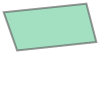

In [3]:
df_aoi = gpd.read_file('aois/Aleutians_pathNumber95.geojson')
aoi = df_aoi.geometry.unary_union
aoi

In [4]:
df_aoi

,aoi_name,path_number,min_days_backward,month_range_lower,month_range_upper,num_neighbors_ref,geometry
0,Aleutians,95,364,6,10,3,"POLYGON Z ((-169.81786 54.53305 0.00000, -165...."
1,Aleutians,95,0,6,10,3,"POLYGON Z ((-169.81786 54.53305 0.00000, -165...."


# Parameters

In [5]:
today = datetime.datetime.now()

START_YEAR = 2016
END_YEAR = today.year
MONTHS_OF_INTEREST = [6, 7, 8, 9, 10]

In [6]:
reference_dates = [datetime.datetime(year, month, 1) 
                   for year in range(START_YEAR, END_YEAR + 1)
                   for month in MONTHS_OF_INTEREST
                   if datetime.datetime(year, month, 1) < today]
reference_dates = list(reversed(reference_dates))
reference_dates[:3]

[datetime.datetime(2021, 10, 1, 0, 0),
 datetime.datetime(2021, 9, 1, 0, 0),
 datetime.datetime(2021, 8, 1, 0, 0)]

In [7]:
secondary_dates = [ref_date + relativedelta(months=1) for ref_date in reference_dates]
secondary_dates = secondary_dates[1:] + reference_dates[-1:]
secondary_dates[:3]

[datetime.datetime(2021, 10, 1, 0, 0),
 datetime.datetime(2021, 9, 1, 0, 0),
 datetime.datetime(2021, 8, 1, 0, 0)]

In [8]:
for ref, sec in zip(reference_dates[:6], secondary_dates):
    print('############################')
    print(ref.date(), ' to ', sec.date())
    print('or: days backward', (ref - sec).days)

############################
2021-10-01  to  2021-10-01
or: days backward 0
############################
2021-09-01  to  2021-09-01
or: days backward 0
############################
2021-08-01  to  2021-08-01
or: days backward 0
############################
2021-07-01  to  2021-07-01
or: days backward 0
############################
2021-06-01  to  2020-11-01
or: days backward 212
############################
2020-10-01  to  2020-10-01
or: days backward 0


In [9]:
path_numbers = df_aoi.path_number.unique().tolist()
path_numbers

[95]

# Generate tiles used for coverage

This function just does a geometric query based on each frame and using one pass from the start date.

In [55]:
df_coverage_tiles = get_s1_coverage_tiles(aoi,
                                          # the date is used to get coverage tiles for extracting stack.
                                          # Recent data has reliable coverage.
                                          start_date=datetime.datetime(2021, 1, 1))

<AxesSubplot:>

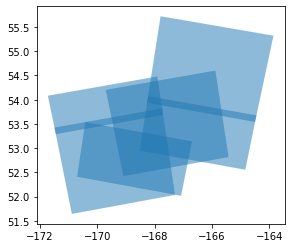

In [57]:
df_coverage_tiles.plot(alpha=.5)

# Generate a stack

Using all the tiles that are needed to cover the AOI.

In [58]:
df_stack = get_s1_stack_by_dataframe(df_coverage_tiles,
                                     path_numbers=path_numbers)

Filter by month.

In [59]:
df_stack_month = df_stack[df_stack.start_date.dt.month.isin(MONTHS_OF_INTEREST)]
df_stack_month.shape

(57, 27)

<AxesSubplot:>

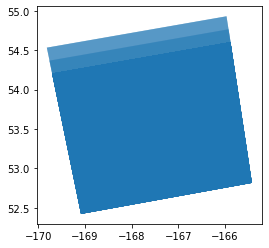

In [61]:
df_stack_month.plot(alpha=.24)

In [13]:
ifg_pairs = []

for ref_date, sec_date in zip(tqdm(reference_dates), (secondary_dates)):
    min_days_backward = (ref_date - sec_date).days
    temporal_window_days=364 * 3
    temp = enumerate_ifgs_from_stack(df_stack_month,
                                     aoi,
                                     ref_date,
                                     enumeration_type='tile',
                                     min_days_backward=(ref_date - sec_date).days,
                                     num_neighbors_ref=3,
                                     num_neighbors_sec=3,
                                     temporal_window_days=temporal_window_days,
                                     )
    ifg_pairs += temp

100%|██████████| 30/30 [01:31<00:00,  3.05s/it]


The numer of GUNWs will be the number of rows i.e.:

# Get Dataframe

In [14]:
df_pairs = distill_all_pairs(ifg_pairs)
df_pairs.head()

,reference,secondary,reference_date,secondary_date,path_number,geometry
0,[S1B_IW_SLC__1SDV_20211005T045609_20211005T045...,[S1B_IW_SLC__1SDV_20210923T045609_20210923T045...,2021-10-05,2021-09-23,95,"POLYGON ((-165.88269 54.60060, -165.88269 54.6..."
1,[S1B_IW_SLC__1SDV_20211005T045609_20211005T045...,[S1B_IW_SLC__1SDV_20210911T045609_20210911T045...,2021-10-05,2021-09-11,95,"POLYGON ((-165.88269 54.60060, -165.88269 54.6..."
2,[S1B_IW_SLC__1SDV_20211005T045609_20211005T045...,[S1B_IW_SLC__1SDV_20210830T045608_20210830T045...,2021-10-05,2021-08-30,95,"POLYGON ((-169.08579 52.42376, -169.08579 52.4..."
3,[S1B_IW_SLC__1SDV_20211017T045609_20211017T045...,[S1B_IW_SLC__1SDV_20210923T045609_20210923T045...,2021-10-17,2021-09-23,95,"POLYGON ((-165.88384 54.60104, -165.88384 54.6..."
4,[S1B_IW_SLC__1SDV_20211017T045609_20211017T045...,[S1B_IW_SLC__1SDV_20210911T045609_20210911T045...,2021-10-17,2021-09-11,95,"POLYGON ((-165.88373 54.60061, -165.88372 54.6..."


In [15]:
f"# of GUNWs: ' {df_pairs.shape[0]}"

"# of GUNWs: ' 270"

# Deduplication Pt. 1

In [16]:
import hashlib
import json


def get_gunw_hash_id(reference_ids: list, secondary_ids: list) -> str:
    all_ids = json.dumps([' '.join(sorted(reference_ids)),
                          ' '.join(sorted(secondary_ids))
                          ]).encode('utf8')
    hash_id = hashlib.md5(all_ids).hexdigest()
    return hash_id

In [17]:
def hasher(row):
    return get_gunw_hash_id(row['reference'], row['secondary'])

df_pairs['hash_id'] = df_pairs.apply(hasher, axis=1)
df_pairs.head()

,reference,secondary,reference_date,secondary_date,path_number,geometry,hash_id
0,[S1B_IW_SLC__1SDV_20211005T045609_20211005T045...,[S1B_IW_SLC__1SDV_20210923T045609_20210923T045...,2021-10-05,2021-09-23,95,"POLYGON ((-165.88269 54.60060, -165.88269 54.6...",9fc7424d3392c1252360ca4dd41a8c7b
1,[S1B_IW_SLC__1SDV_20211005T045609_20211005T045...,[S1B_IW_SLC__1SDV_20210911T045609_20210911T045...,2021-10-05,2021-09-11,95,"POLYGON ((-165.88269 54.60060, -165.88269 54.6...",366038be5db108e7e9428b700647372b
2,[S1B_IW_SLC__1SDV_20211005T045609_20211005T045...,[S1B_IW_SLC__1SDV_20210830T045608_20210830T045...,2021-10-05,2021-08-30,95,"POLYGON ((-169.08579 52.42376, -169.08579 52.4...",f8dd4bf27ce510c7c1a3d4050d2217f2
3,[S1B_IW_SLC__1SDV_20211017T045609_20211017T045...,[S1B_IW_SLC__1SDV_20210923T045609_20210923T045...,2021-10-17,2021-09-23,95,"POLYGON ((-165.88384 54.60104, -165.88384 54.6...",af3dbfc55e04d492ff44685a0a027bc7
4,[S1B_IW_SLC__1SDV_20211017T045609_20211017T045...,[S1B_IW_SLC__1SDV_20210911T045609_20210911T045...,2021-10-17,2021-09-11,95,"POLYGON ((-165.88373 54.60061, -165.88372 54.6...",24e39fcfd21423625cf927bebea0b3df


In [18]:
f"# of duplicated entries: {df_pairs.duplicated(subset=['hash_id']).sum()}"

'# of duplicated entries: 82'

In [19]:
df_pairs = df_pairs.drop_duplicates(subset=['hash_id']).reset_index(drop=True)
f"# of UNIQUE GUNWs: {df_pairs.shape[0]}"

'# of UNIQUE GUNWs: 188'

# Update types for Graphical Analysis

In [20]:
df_pairs['reference_date'] = pd.to_datetime(df_pairs['reference_date'])
df_pairs['secondary_date'] = pd.to_datetime(df_pairs['secondary_date'])
df_pairs.head()

,reference,secondary,reference_date,secondary_date,path_number,geometry,hash_id
0,[S1B_IW_SLC__1SDV_20211005T045609_20211005T045...,[S1B_IW_SLC__1SDV_20210923T045609_20210923T045...,2021-10-05,2021-09-23,95,"POLYGON ((-165.88269 54.60060, -165.88269 54.6...",9fc7424d3392c1252360ca4dd41a8c7b
1,[S1B_IW_SLC__1SDV_20211005T045609_20211005T045...,[S1B_IW_SLC__1SDV_20210911T045609_20210911T045...,2021-10-05,2021-09-11,95,"POLYGON ((-165.88269 54.60060, -165.88269 54.6...",366038be5db108e7e9428b700647372b
2,[S1B_IW_SLC__1SDV_20211005T045609_20211005T045...,[S1B_IW_SLC__1SDV_20210830T045608_20210830T045...,2021-10-05,2021-08-30,95,"POLYGON ((-169.08579 52.42376, -169.08579 52.4...",f8dd4bf27ce510c7c1a3d4050d2217f2
3,[S1B_IW_SLC__1SDV_20211017T045609_20211017T045...,[S1B_IW_SLC__1SDV_20210923T045609_20210923T045...,2021-10-17,2021-09-23,95,"POLYGON ((-165.88384 54.60104, -165.88384 54.6...",af3dbfc55e04d492ff44685a0a027bc7
4,[S1B_IW_SLC__1SDV_20211017T045609_20211017T045...,[S1B_IW_SLC__1SDV_20210911T045609_20210911T045...,2021-10-17,2021-09-11,95,"POLYGON ((-165.88373 54.60061, -165.88372 54.6...",24e39fcfd21423625cf927bebea0b3df


# Visualize a Date Graph from Time Series

We can put this into a network Directed Graph and use some simple network functions to check connectivity.

We are going to use just dates for nodes, though you could use `(ref_date, slc_id)` for nodes and then inspect connected components.

In [21]:
list(zip(df_pairs.reference_date, df_pairs.secondary_date))[:15]

[(Timestamp('2021-10-05 00:00:00'), Timestamp('2021-09-23 00:00:00')),
 (Timestamp('2021-10-05 00:00:00'), Timestamp('2021-09-11 00:00:00')),
 (Timestamp('2021-10-05 00:00:00'), Timestamp('2021-08-30 00:00:00')),
 (Timestamp('2021-10-17 00:00:00'), Timestamp('2021-09-23 00:00:00')),
 (Timestamp('2021-10-17 00:00:00'), Timestamp('2021-09-11 00:00:00')),
 (Timestamp('2021-10-17 00:00:00'), Timestamp('2021-08-30 00:00:00')),
 (Timestamp('2021-10-29 00:00:00'), Timestamp('2021-09-23 00:00:00')),
 (Timestamp('2021-10-29 00:00:00'), Timestamp('2021-09-11 00:00:00')),
 (Timestamp('2021-10-29 00:00:00'), Timestamp('2021-08-30 00:00:00')),
 (Timestamp('2021-09-11 00:00:00'), Timestamp('2021-08-30 00:00:00')),
 (Timestamp('2021-09-11 00:00:00'), Timestamp('2021-08-18 00:00:00')),
 (Timestamp('2021-09-11 00:00:00'), Timestamp('2021-08-06 00:00:00')),
 (Timestamp('2021-09-23 00:00:00'), Timestamp('2021-08-30 00:00:00')),
 (Timestamp('2021-09-23 00:00:00'), Timestamp('2021-08-18 00:00:00')),
 (Time

In [22]:
unique_dates = df_pairs.reference_date.tolist() + df_pairs.secondary_date.tolist()
unique_dates = sorted(list(set(unique_dates)))
unique_dates[:4]

[Timestamp('2015-07-27 00:00:00'),
 Timestamp('2015-08-20 00:00:00'),
 Timestamp('2015-10-07 00:00:00'),
 Timestamp('2016-06-03 00:00:00')]

In [23]:
date2node = {date: k for (k, date) in enumerate(unique_dates)}
node2date = {k: date for (date, k) in date2node.items()}

In [24]:
G = nx.DiGraph()

edges = [(date2node[ref_date], date2node[sec_date]) 
         for (ref_date, sec_date) in zip(df_pairs.reference_date, df_pairs.secondary_date)]
G.add_edges_from(edges)

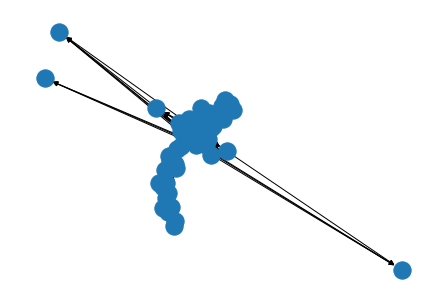

In [25]:
nx.draw(G)

This function checks there is a path from the first date to the last one.

In [26]:
nx.has_path(G, 
            target=date2node[unique_dates[0]],
            source=date2node[unique_dates[-1]])

True

The y-axis is created purely for display so doesn't really indicated anything but flow by month.

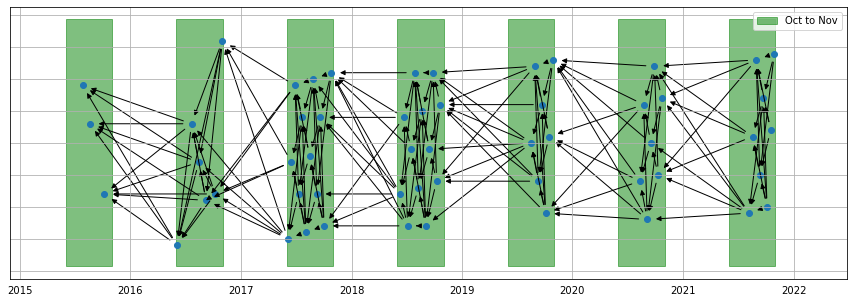

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))

increment = [date.month + date.day for date in unique_dates]

# source: https://stackoverflow.com/a/27852570
scat = ax.scatter(unique_dates, increment)
position = scat.get_offsets().data

pos = {date2node[date]: position[k] for (k, date) in enumerate(unique_dates)}
nx.draw_networkx_edges(G, pos=pos, ax=ax)
ax.grid('on')
ax.tick_params(axis='x',
               which='major',
               labelbottom=True,
               labelleft=True)
ymin, ymax = ax.get_ylim()
for y in range(2015, 2022):
    label = 'Oct to Nov' if y == 2016 else None
    ax.fill_between([datetime.datetime(y, 6, 1), datetime.datetime(y, 11, 1)], 
                    ymin, ymax, 
                    alpha=.5, color='green', zorder=0, label=label)
plt.legend()

# Deduplication Pt. 2

# Check CMR

In [28]:
from s1_enumerator import duplicate_gunw_found
import concurrent
from tqdm import tqdm

n = df_pairs.shape[0]
with concurrent.futures.ThreadPoolExecutor(max_workers=15) as executor:
    results = list(tqdm(executor.map(duplicate_gunw_found, df_pairs.to_dict('records')), total=n))

  0%|          | 0/188 [00:00<?, ?it/s]/Users/cmarshak/bekaert-team/s1-enumerator/s1_enumerator/formatter.py:17: UserWarning: Dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
100%|██████████| 188/188 [00:31<00:00,  5.98it/s]


In [29]:
df_pairs['existing_gunw'] = [r != '' for r in results]
df_pairs['existing_gunw_id'] = results
total_existing_gunws = df_pairs['existing_gunw'].sum()
print('existing_gunws: ', total_existing_gunws)
print('Total pairs', df_pairs.shape[0])

existing_gunws:  0
Total pairs 188


In [30]:
df_pairs_filtered = df_pairs[~df_pairs['existing_gunw']].reset_index(drop=True)
# df_pairs_filtered.drop_duplicates(subset=['hash_id'], inplace=True)
print('after filtering, total pairs: ', df_pairs_filtered.shape[0])

after filtering, total pairs:  188


# Check Hyp3 Account

Two parts:

1. check s3 bucket
2. check running/pending jobs

In [31]:
import hyp3_sdk

# uses .netrc; add `prompt=True` to prompt for credentials; 
hyp3_isce = hyp3_sdk.HyP3('https://hyp3-isce.asf.alaska.edu/')

In [39]:
pending_jobs = (hyp3_isce.find_jobs(name='final_test_95',
                                    status_code='PENDING') +  \
                hyp3_isce.find_jobs(status_code='RUNNING'))

# Specifying job name
all_jobs = hyp3_isce.find_jobs(name='final_test_95_try2')

In [40]:
print(all_jobs)

0 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 0 pending.


## a) Get existing products in s3 bucket

In [ ]:
# job_data = [j.to_dict() for j in all_jobs]
# job_data[0]

Get bucket (there is only one)

In [ ]:
job_data_s3 = list(filter(lambda job: 'files' in job.keys(), job_data))
len(job_data_s3)

In [ ]:
bucket = job_data_s3[0]['files'][0]['s3']['bucket']
bucket

Get all keys

In [ ]:
job_keys = [job['files'][0]['s3']['key'] for job in job_data_s3]
job_keys[0]

In [ ]:
s3 = boto3.resource('s3')
prod_bucket = s3.Bucket(bucket)

objects = list(prod_bucket.objects.all())
ncs = list(filter(lambda x: x.key.endswith('.nc'), objects))
ncs[:10]

Need to physically check if the products are not there (could have been deleted!)

In [ ]:
nc_keys = [nc_ob.key for nc_ob in ncs]
jobs_with_prods_in_s3 = [job for (k, job) in enumerate(job_data_s3) if job_keys[k] in nc_keys]
len(jobs_with_prods_in_s3)

In [ ]:
slcs = [(job['job_parameters']['granules'],
         job['job_parameters']['secondary_granules']) 
        for job in jobs_with_prods_in_s3]
slcs[:2]

In [ ]:
hash_ids_of_prods_in_s3 = [get_gunw_hash_id(*slc) for slc in slcs]
hash_ids_of_prods_in_s3[0]

In [ ]:
f"We are removing {df_pairs_filtered['hash_id'].isin(hash_ids_of_prods_in_s3).sum()} GUNWs for submission"

In [ ]:
items = hash_ids_of_prods_in_s3
df_pairs_filtered = df_pairs_filtered[~df_pairs_filtered['hash_id'].isin(items)].reset_index(drop=True)
f"Current # of GUNWs: {df_pairs_filtered.shape[0]}"

## b) Running or Pending Jobs

In [41]:
pending_job_data = [j.to_dict() for j in pending_jobs]
pending_slcs = [(job['job_parameters']['granules'],
                 job['job_parameters']['secondary_granules']) 
                 for job in pending_job_data]

In [42]:
hash_ids_of_pending_jobs = [get_gunw_hash_id(*slc) for slc in pending_slcs]
hash_ids_of_pending_jobs[:4]

[]

In [43]:
items = hash_ids_of_pending_jobs
f"We are removing {df_pairs_filtered['hash_id'].isin(items).sum()} GUNWs for submission"

'We are removing 0 GUNWs for submission'

In [44]:
items = hash_ids_of_pending_jobs
df_pairs_filtered = df_pairs_filtered[~df_pairs_filtered['hash_id'].isin(items)].reset_index(drop=True)
f"Current # of GUNWs: {df_pairs_filtered.shape[0]}"

'Current # of GUNWs: 188'

# Submit jobs to Hyp3

In [45]:
records_to_submit = df_pairs_filtered.to_dict('records')
records_to_submit[0]

{'reference': ['S1B_IW_SLC__1SDV_20211005T045609_20211005T045639_028996_0375C6_4753'],
 'secondary': ['S1B_IW_SLC__1SDV_20210923T045609_20210923T045639_028821_037082_B57B'],
 'reference_date': Timestamp('2021-10-05 00:00:00'),
 'secondary_date': Timestamp('2021-09-23 00:00:00'),
 'path_number': 95,
 'geometry': <shapely.geometry.polygon.Polygon at 0x7fcd283b0e80>,
 'hash_id': '9fc7424d3392c1252360ca4dd41a8c7b',
 'existing_gunw': False,
 'existing_gunw_id': ''}

In [46]:
import hyp3_sdk

# uses .netrc; add `prompt=True` to prompt for credentials; 
hyp3_isce = hyp3_sdk.HyP3('https://hyp3-isce.asf.alaska.edu/')

The below puts the records in a format that we can submit to the Hyp3 API.

**Note 1**: there is an index in the records to submit to ensure we don't over submit jobs for generating GUNWs. \
**Note 2**: uncomment the code to *actually* submit the jobs.

In [47]:
len(records_to_submit)

188

In [50]:
import hyp3_sdk

# uses .netrc; add `prompt=True` to prompt for credentials; 
hyp3_isce = hyp3_sdk.HyP3('https://hyp3-isce.asf.alaska.edu/')

job_dicts = [{'name': 'final_test_95_try2',
              'job_type': 'INSAR_ISCE_TEST',
              'job_parameters': {'granules': r['reference'],
                                 'secondary_granules': r['secondary']}} 
             # NOTE THERE IS AN INDEX - this is to submit only a subset of Jobs
             for r in records_to_submit[:]]


# UNCOMMENT TO SUBMIT
# submitted_jobs = hyp3_isce.submit_prepared_jobs(job_dicts)

In [63]:
submitted_jobs_2 = hyp3_isce.find_jobs(name='final_test_95_try2')
print(submitted_jobs_2)

188 HyP3 Jobs: 172 succeeded, 0 failed, 16 running, 0 pending.


In [ ]:
# import concurrent.futures
# from tqdm import tqdm

# with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
#     results = list(tqdm(executor.map(lambda job: job.download_files('products'), jobs), total=len(jobs)))